In [1]:
import warnings
warnings.filterwarnings('ignore') # Aren't I the checky git

In [229]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import scipy

from datetime                import datetime
from sklearn.metrics         import classification_report as cr 
from sklearn.metrics         import r2_score as r2
from sklearn.metrics         import accuracy_score as ac 
from sklearn.metrics         import mean_squared_error as mse
from sklearn.metrics         import confusion_matrix as cm
from sklearn.model_selection import train_test_split as tts

from sklearn.naive_bayes     import GaussianNB                 as GNB
from sklearn.naive_bayes     import MultinomialNB              as MNB
from sklearn.ensemble        import GradientBoostingClassifier as GBC 
from sklearn.ensemble        import RandomForestClassifier     as RFC
from sklearn.svm             import SVC                        as SVC
from sklearn.neighbors       import KNeighborsClassifier       as KNC
from sklearn.linear_model    import LogisticRegression         as LRE
from sklearn.linear_model    import LogisticRegressionCV       as LRC

In [3]:
# plt.figure(figsize=[20,20])
# sns.heatmap(df.corr())
# plt.show()

In [4]:
# pds.get_dummies(df["disp_determinant/medical_code"])

In [5]:
df = pds.read_csv('insight-full.csv', header=0)
incoming_size = len(df)
df = df[(df['transport_code'].isnull()==False)  & (df['disp_problem_lvl'].isnull()==False) & 
        (df['latitude'].isnull()==False)        & (df['longitude'].isnull()==False) &
        (df['trans_score_mod'].isnull()==False) & (df['treat_score_mod'].isnull()==False) &
        (df['disp_problem_lvl']!='UNKNOWN')     & (df['age_yrs'].isnull()==False) &
        (df['sex'].isnull()==False)             & (df['sex']!='U') & (df['age_yrs']>0) &
        (df['disp_determinant/medical_code'].isnull()==False) &
        (df['disp_determinant/medical_code']!='XXXXX')]
df = df[(df['incidentcount'].isnull()==False) & (df['onscene_time'].isnull()==False)]
df.index = range(len(df))
outgoing_size = len(df)
print('Read in {0} events, working with {1} events.'.format(incoming_size, outgoing_size))
print('{} cut events'.format(incoming_size-outgoing_size))

Read in 342940 events, working with 311866 events.
31074 cut events


# Developing Classifications

How do we rate things as emergency or not?


In [6]:
# print(df['transport_code'].unique())

A level 10 transport code is an acute trama and needs the full response.  These should correspond to L1 response from the dispatcher

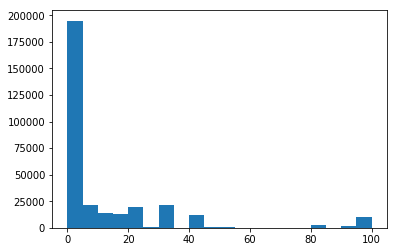

In [7]:
plt.hist(df['trans_score_mod'],bins=20)
plt.show()

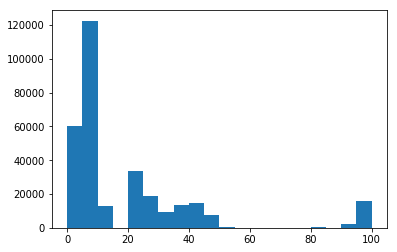

In [8]:
plt.hist(df['treat_score_mod'],bins=20)
plt.show()

#### Classification from documentation
According to the document I was given classification should be:

Low:  treat: 0 - 20,     trans: 0 - 12

Med:  treat: 20 - 92.5,  trans: 12 - 90

High: treat: 92.5 - 100, trans: 90 - 100

The final classification is determined by the highest catagory

In [9]:
df['class'] = 0

df['class'][(df['treat_score_mod'] > 92.4) | (df['trans_score_mod'] > 89.9) | 
            (df['transport_code'] == 10)] = 'L1'
df['class'][(df['treat_score_mod'] < 20)   & (df['trans_score_mod'] < 12)]   = 'L4'
df['class'][df['class']==0] = 'L3'

In [10]:
temp = pds.get_dummies(df['class'])
df = pds.concat([df,temp],axis=1)
# print(df['L3'])

In [11]:
# df[['class','trans_score_mod','treat_score_mod']].head(15)

#### Classifications:

High = L1

Medium = L3

Low = L4

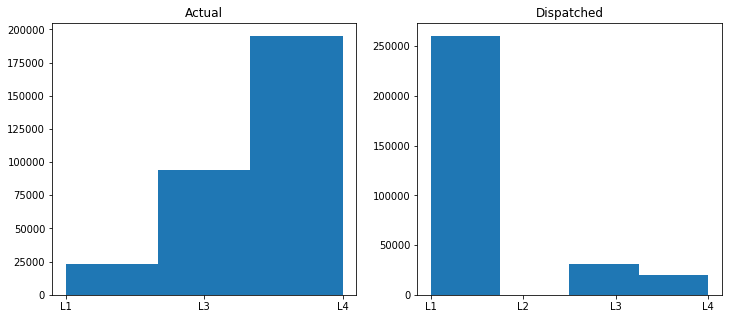

In [198]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1), plt.title('Actual')
plt.hist(df['class'],bins=3)
plt.subplot(1,2,2), plt.title('Dispatched')
plt.hist(df['disp_problem_lvl'],bins=4)
plt.show()

# Prepare Time Feature

Turn time of day into an float between 0 - 24 by the minute and bin into groups of 15 minutes.

In [12]:
temp0 = df['response_date'].apply(lambda x: x.replace('.000', ''))
temp0 = temp0.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
temp1 = temp0.apply(lambda x: x.time())
temp2 = temp0.apply(lambda x: x.weekday())
# temp3 = temp0.apply(lambda x: x.month() )

temp2 = ['Monday' if x==0 else 'Tuesday'  if x==1 else 'Wednesday' if x==2 else 'Thursday' if x==3 else
         'Friday' if x==4 else 'Saturday' if x==5 else 'Sunday' for x in temp2]

df['response_time'] = temp0.apply(lambda x: x.hour+x.minute/60.)
temp2 = pds.get_dummies(temp2)
df    = pds.concat([df,temp2],axis=1)
# df['Monday'].head(5)

Time is in float types, need to bin the data.

In [13]:
# df['response_date'] = df['response_date'].apply(lambda x: int(x*4)/4.)
# df['response_date'].head(5)

#### Time is formatted.  Decided not to bin

# Preparing sex

Need to change sex from M/F to 0/1

In [14]:
df['gender']                 = 0
df['gender'][df['sex']=='F'] = 1
df['gender'][df['sex']=='M'] = 0
# df['gender'][df['sex']=='M'].head(5)

#### Nothing could be simpler

# What about frequency of calls?

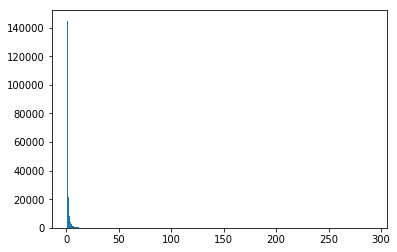

In [15]:
plt.hist(df.groupby('mpi_id')['incidentcount'].mean().values,bins=300)
# print(list(df.groupby('mpi_id')['incidentcount'].mean().values))
plt.show()

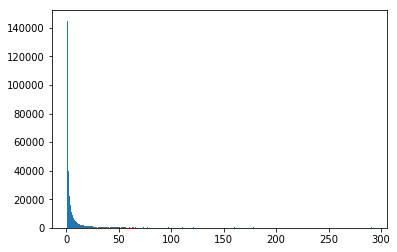

In [16]:
plt.hist(df['incidentcount'],bins=300)
plt.show()

#### Let's go ahead and use this as well.

# Response time
Maybe how long the ambulance takes to reach the person could help inform the model as well

In [17]:
ti = df['response_date'].apply(lambda x: x.replace('.000', ''))
ti = ti.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
ti = ti.apply(lambda x: x.hour+x.minute/60.+x.second/3600)

tf = df['onscene_time'].apply(lambda x: x.replace('.000', ''))
tf = tf.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
tf = tf.apply(lambda x: x.hour+x.minute/60.+x.second/3600)

In [18]:
tt = tf-ti
tt[tt<0] = tt+24
df['delta_arrival'] = tt
# tt = tt.apply(lambda x: x.hour + x.minute/60 + x.seconds/3600)
# print(tt)

#### Now we have how long it takes from the first call until arrival

# Choosing problems to work on

Only going to work on the biggest dispatch code to begin with.  I think this makes more sense than trying to do everything together.

In [19]:
code_list = list(df['disp_determinant/medical_code'].unique())
code_dict = {}
for i in range(len(code_list)):
    code_dict[code_list[i]] = i

In [127]:
for code in code_list:
    if len(df['disp_determinant/medical_code'][df['disp_determinant/medical_code']==code]) > 7500:
        print(code)

31D03
26C02
26A01
06D02
26D01
31D02
06C01
17B01
29B04


#### Let's pull out every time this situation comes up, no matter the response level

In [21]:
df['event'] = [x[:2]+x[3:] for x in df['disp_determinant/medical_code']]

#### Then serialize the response level part of the code

In [22]:
df['disp_level_code'] = 0
df['disp_level_code'] = [x[2] for x in df['disp_determinant/medical_code']]

In [23]:
df['disp_level_code'].unique()

array(['B', 'C', 'D', 'A', 'E', 'O'], dtype=object)

In [24]:
df['A'] = 0; df['A'][df['disp_level_code']=='A'] = 1
df['B'] = 0; df['B'][df['disp_level_code']=='B'] = 1
df['C'] = 0; df['C'][df['disp_level_code']=='C'] = 1
df['D'] = 0; df['D'][df['disp_level_code']=='D'] = 1
df['E'] = 0; df['E'][df['disp_level_code']=='E'] = 1
df['O'] = 0; df['O'][df['disp_level_code']=='O'] = 1

#### Creating a df for each of these so they don't get confused

In [25]:
df_3103 = df[df['event']=='3103']
df_0602 = df[df['event']=='0602']
df_2601 = df[df['event']=='2601']
df_1701 = df[df['event']=='1701']
df_2904 = df[df['event']=='2904']

#### We now have 5 types of incidents to look at

# What do I have?
gender

age_yrs

A B C D E O

delta_arrival

response_time

Monday Tuesday Wenesday Thursday Friday Saturday Sunday

incidentcount

class

#### These will be examined for specific events (types of injuries)

# Let's get ready

In [26]:
print(len(df_3103))
print(len(df_0602))
print(len(df_2601))
print(len(df_1701))
print(len(df_2904))

12132
14301
33118
20076
10160


In [27]:
train_0602, test_0602 = tts(df_0602, test_size=0.2)
train_1701, test_1701 = tts(df_1701, test_size=0.2)
train_2601, test_2601 = tts(df_2601, test_size=0.2)
train_2904, test_2904 = tts(df_2904, test_size=0.2)
train_3103, test_3103 = tts(df_3103, test_size=0.2)

# What does the data look like?

In [28]:
temp = ['response_time', 'age_yrs', 'gender', 'class', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
         'Friday', 'Saturday', 'Sunday','A','B','C','D','O','incidentcount', 'delta_arrival','L1','L3','L4']

       response_time    age_yrs    gender    Monday   Tuesday  Wednesday  \
class                                                                      
L1         12.343992  65.123924  0.483703  0.155802  0.123207   0.137549   
L3         12.568378  61.387040  0.522973  0.154860  0.144975   0.147721   
L4         13.190641  49.279001  0.541976  0.158226  0.147873   0.141571   

       Thursday    Friday  Saturday    Sunday    A    B    C    D    O  \
class                                                                    
L1     0.129726  0.156454  0.153194  0.144068  0.0  0.0  0.0  1.0  0.0   
L3     0.143877  0.135823  0.138569  0.134175  0.0  0.0  0.0  1.0  0.0   
L4     0.148323  0.137295  0.128742  0.137970  0.0  0.0  0.0  1.0  0.0   

       incidentcount  delta_arrival   L1   L3   L4  
class                                               
L1          5.631030       0.155830  1.0  0.0  0.0  
L3          9.018671       0.141585  0.0  1.0  0.0  
L4          9.026784       0.143925 

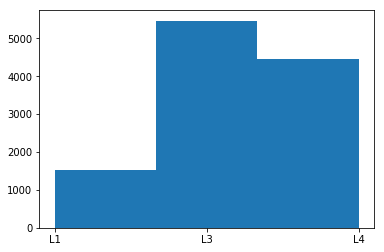

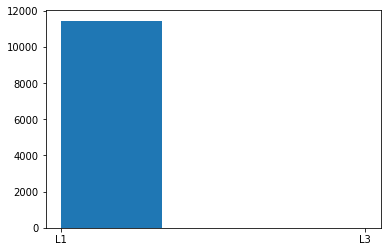

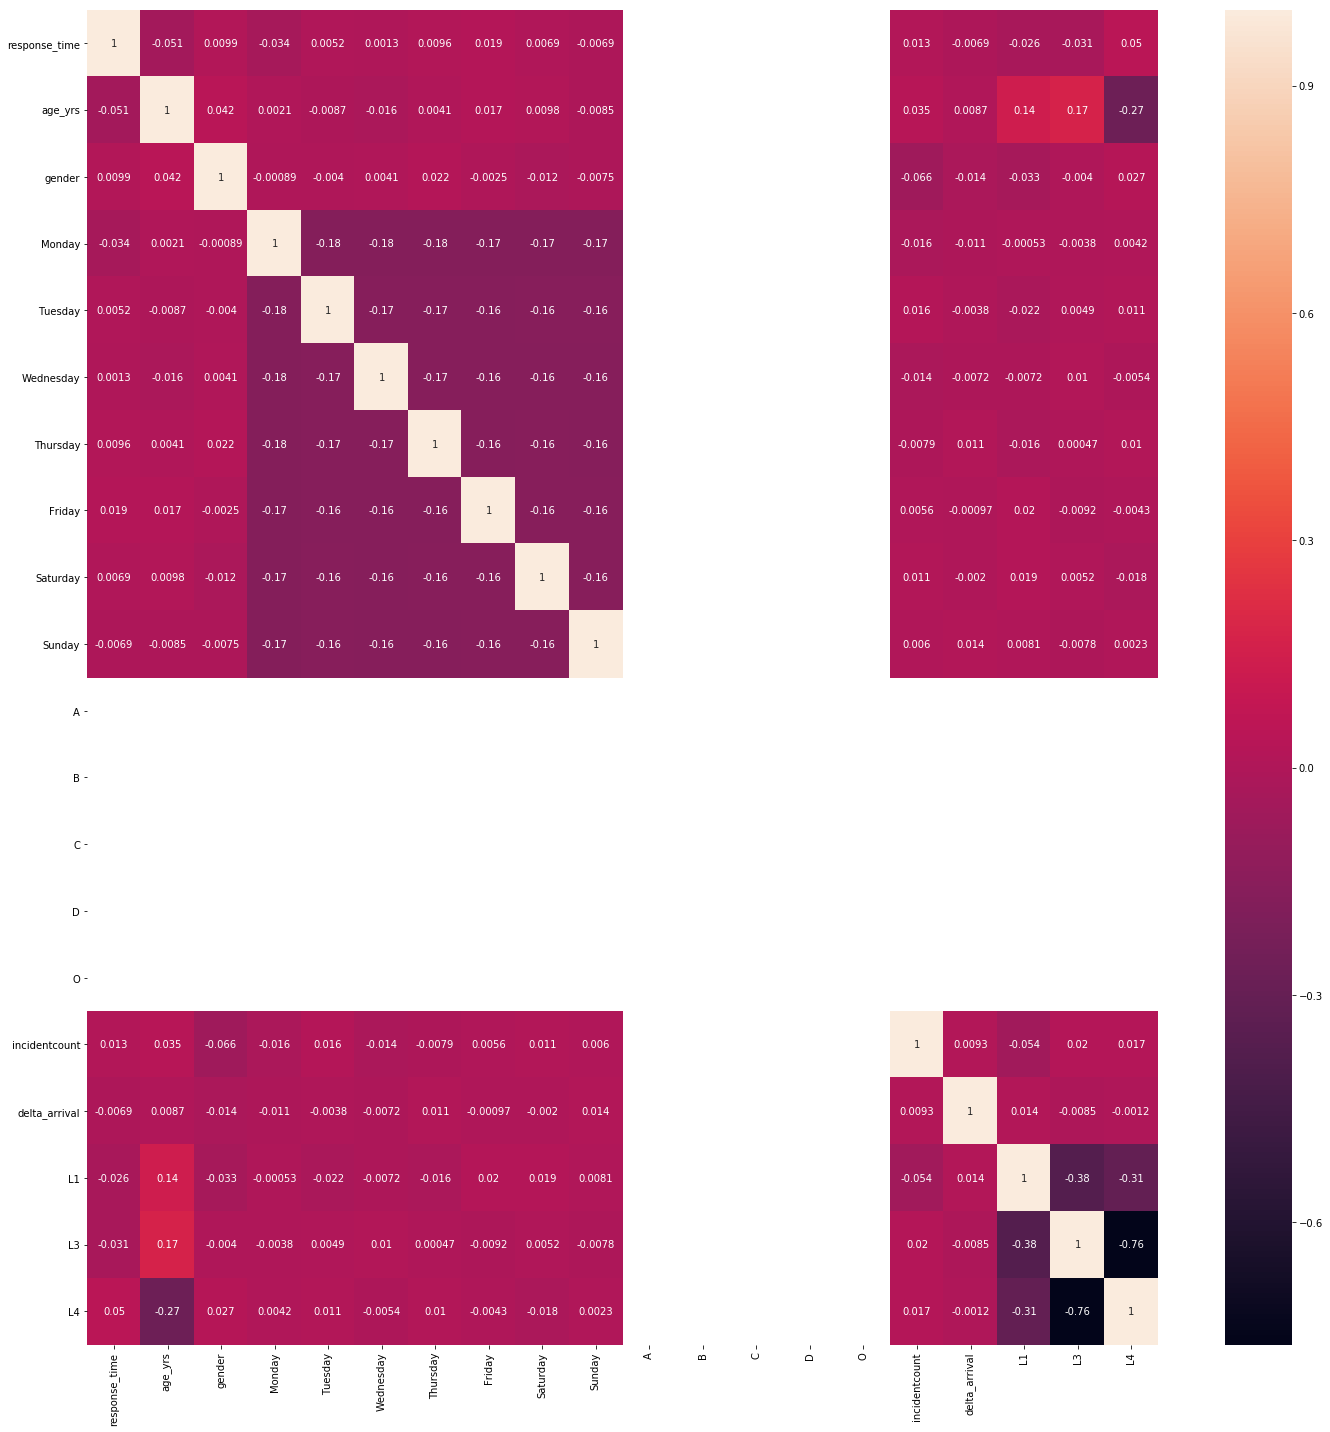

In [29]:
print(train_0602[temp].groupby('class').mean())
# print(train_0602[temp].groupby('class').std())
plt.hist(train_0602['class'],bins=3)
plt.show()
plt.hist(train_0602['disp_problem_lvl'],bins=3)
plt.show()

plt.figure(figsize=[20,20])
corr = train_0602[temp].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

       response_time    age_yrs    gender    Monday   Tuesday  Wednesday  \
class                                                                      
L1         13.973011  67.206629  0.410985  0.130682  0.128788   0.117424   
L3         13.610059  68.435907  0.600752  0.145091  0.141528   0.136580   
L4         13.467468  66.727090  0.574046  0.140744  0.143607   0.141031   

       Thursday    Friday  Saturday    Sunday         A         B    C  \
class                                                                    
L1     0.151515  0.157197  0.164773  0.149621  0.164773  0.812500  0.0   
L3     0.142914  0.142122  0.154196  0.137569  0.320269  0.678741  0.0   
L4     0.145229  0.147901  0.149618  0.131870  0.312309  0.685878  0.0   

              D    O  incidentcount  delta_arrival   L1   L3   L4  
class                                                              
L1     0.022727  0.0       3.857955       0.148965  1.0  0.0  0.0  
L3     0.000990  0.0       4.501386       0.

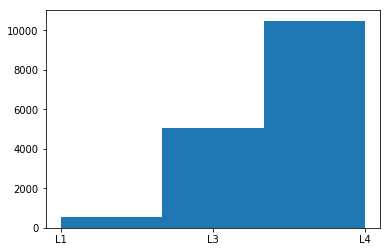

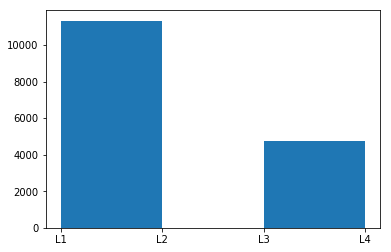

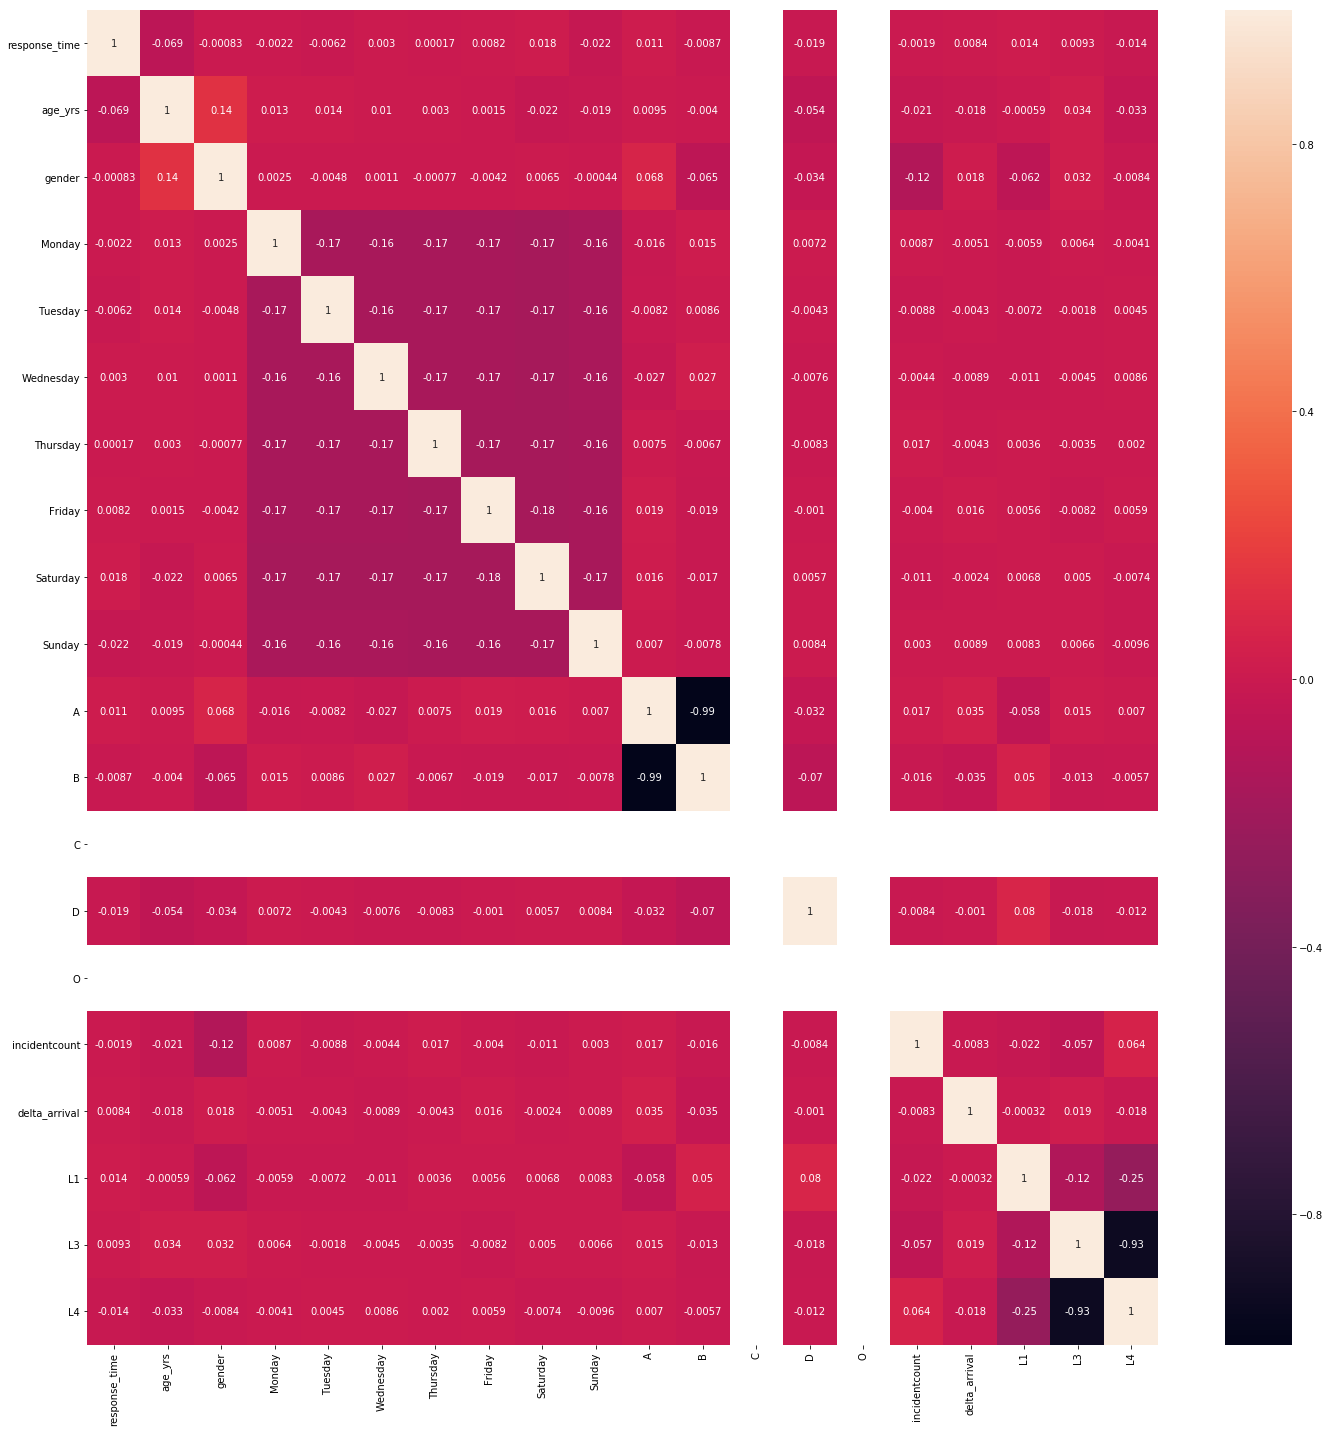

In [30]:
print(train_1701[temp].groupby('class').mean())
# print(train_1701[temp].groupby('class').std())
plt.hist(train_1701['class'],bins=3)
plt.show()
plt.hist(train_1701['disp_problem_lvl'],bins=3)
plt.show()

plt.figure(figsize=[20,20])
corr = train_1701[temp].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

       response_time    age_yrs    gender    Monday   Tuesday  Wednesday  \
class                                                                      
L1         13.337386  61.211930  0.399696  0.140578  0.144377   0.136778   
L3         13.438554  62.443705  0.457234  0.158314  0.148220   0.149283   
L4         13.065601  53.076791  0.435615  0.150581  0.147253   0.149148   

       Thursday    Friday  Saturday    Sunday         A         B         C  \
class                                                                         
L1     0.142857  0.166413  0.132979  0.136018  0.084347  0.130699  0.201368   
L3     0.136533  0.134231  0.136001  0.137418  0.214981  0.163627  0.149283   
L4     0.135733  0.137730  0.139112  0.140443  0.301162  0.204649  0.103681   

              D    O  incidentcount  delta_arrival   L1   L3   L4  
class                                                              
L1     0.583587  0.0       4.948328       0.163978  1.0  0.0  0.0  
L3     0.472109  0.

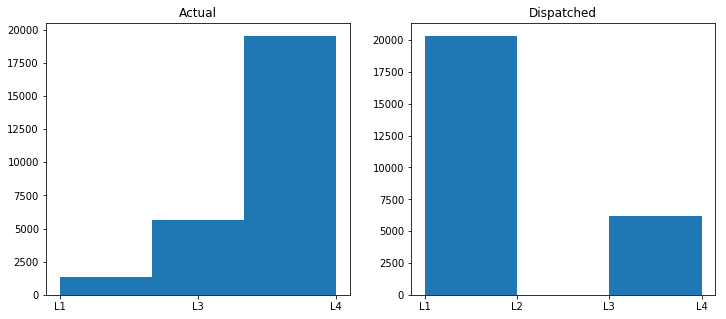

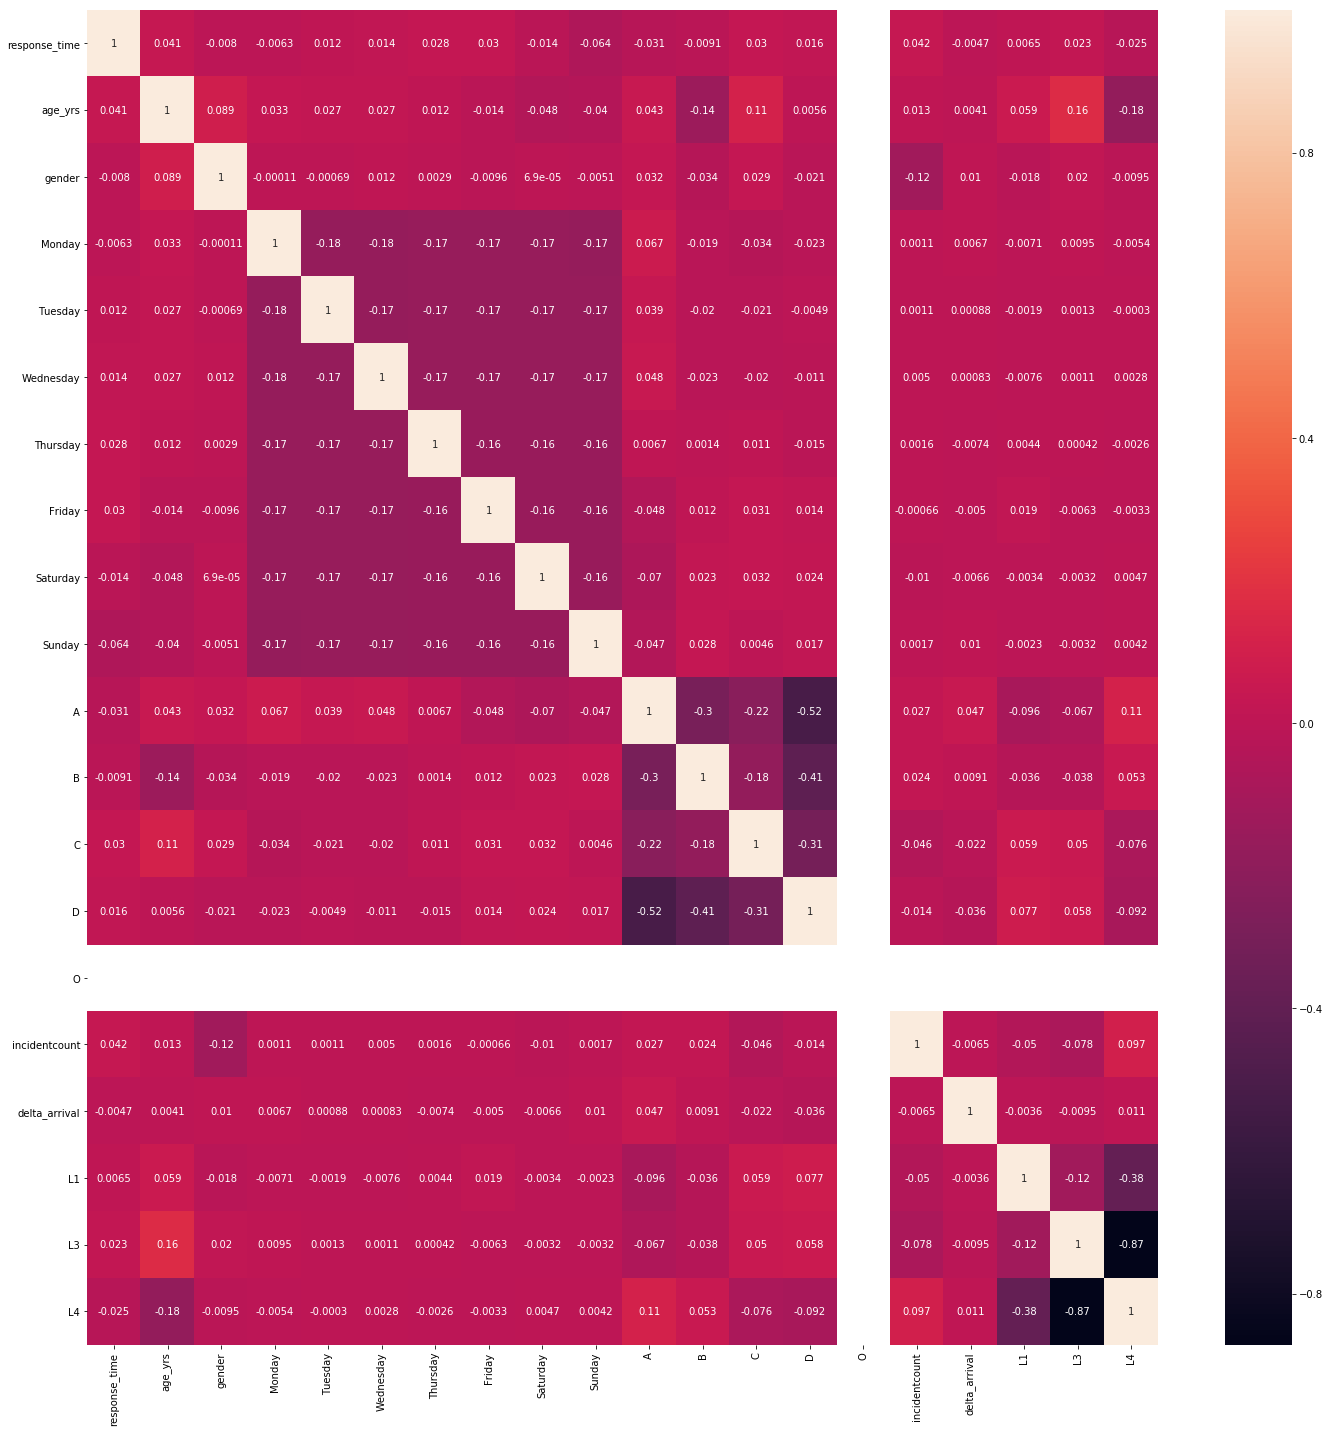

In [135]:
print(train_2601[temp].groupby('class').mean())
# print(train_2601[temp].groupby('class').std())
plt.figure(figsize=[12,5])
plt.subplot(1,2,1), plt.title('Actual')
plt.hist(train_2601['class'],bins=3)
plt.subplot(1,2,2), plt.title('Dispatched')
plt.hist(train_2601['disp_problem_lvl'],bins=3)
plt.show()

plt.figure(figsize=[20,20])
corr = train_2601[temp].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

       response_time    age_yrs    gender    Monday   Tuesday  Wednesday  \
class                                                                      
L1         13.430043  37.908410  0.330896  0.100548  0.133455   0.117002   
L3         13.576774  41.239256  0.538913  0.147822  0.133138   0.127264   
L4         14.107036  36.911376  0.523294  0.132358  0.135609   0.129830   

       Thursday    Friday  Saturday    Sunday    A         B    C         D  \
class                                                                         
L1     0.126143  0.177331  0.164534  0.180987  0.0  1.000000  0.0  0.000000   
L3     0.160059  0.164953  0.133138  0.133627  0.0  0.997553  0.0  0.002447   
L4     0.151860  0.168472  0.141928  0.139942  0.0  0.998375  0.0  0.001625   

         O  incidentcount  delta_arrival   L1   L3   L4  
class                                                    
L1     0.0       1.336380       0.179827  1.0  0.0  0.0  
L3     0.0       1.396476       0.190192  0.0  1.

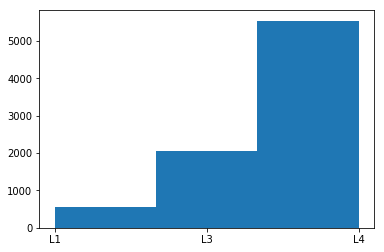

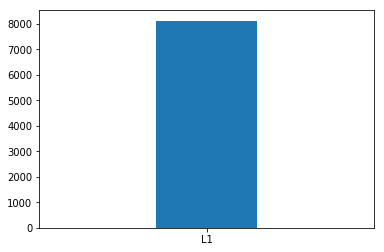

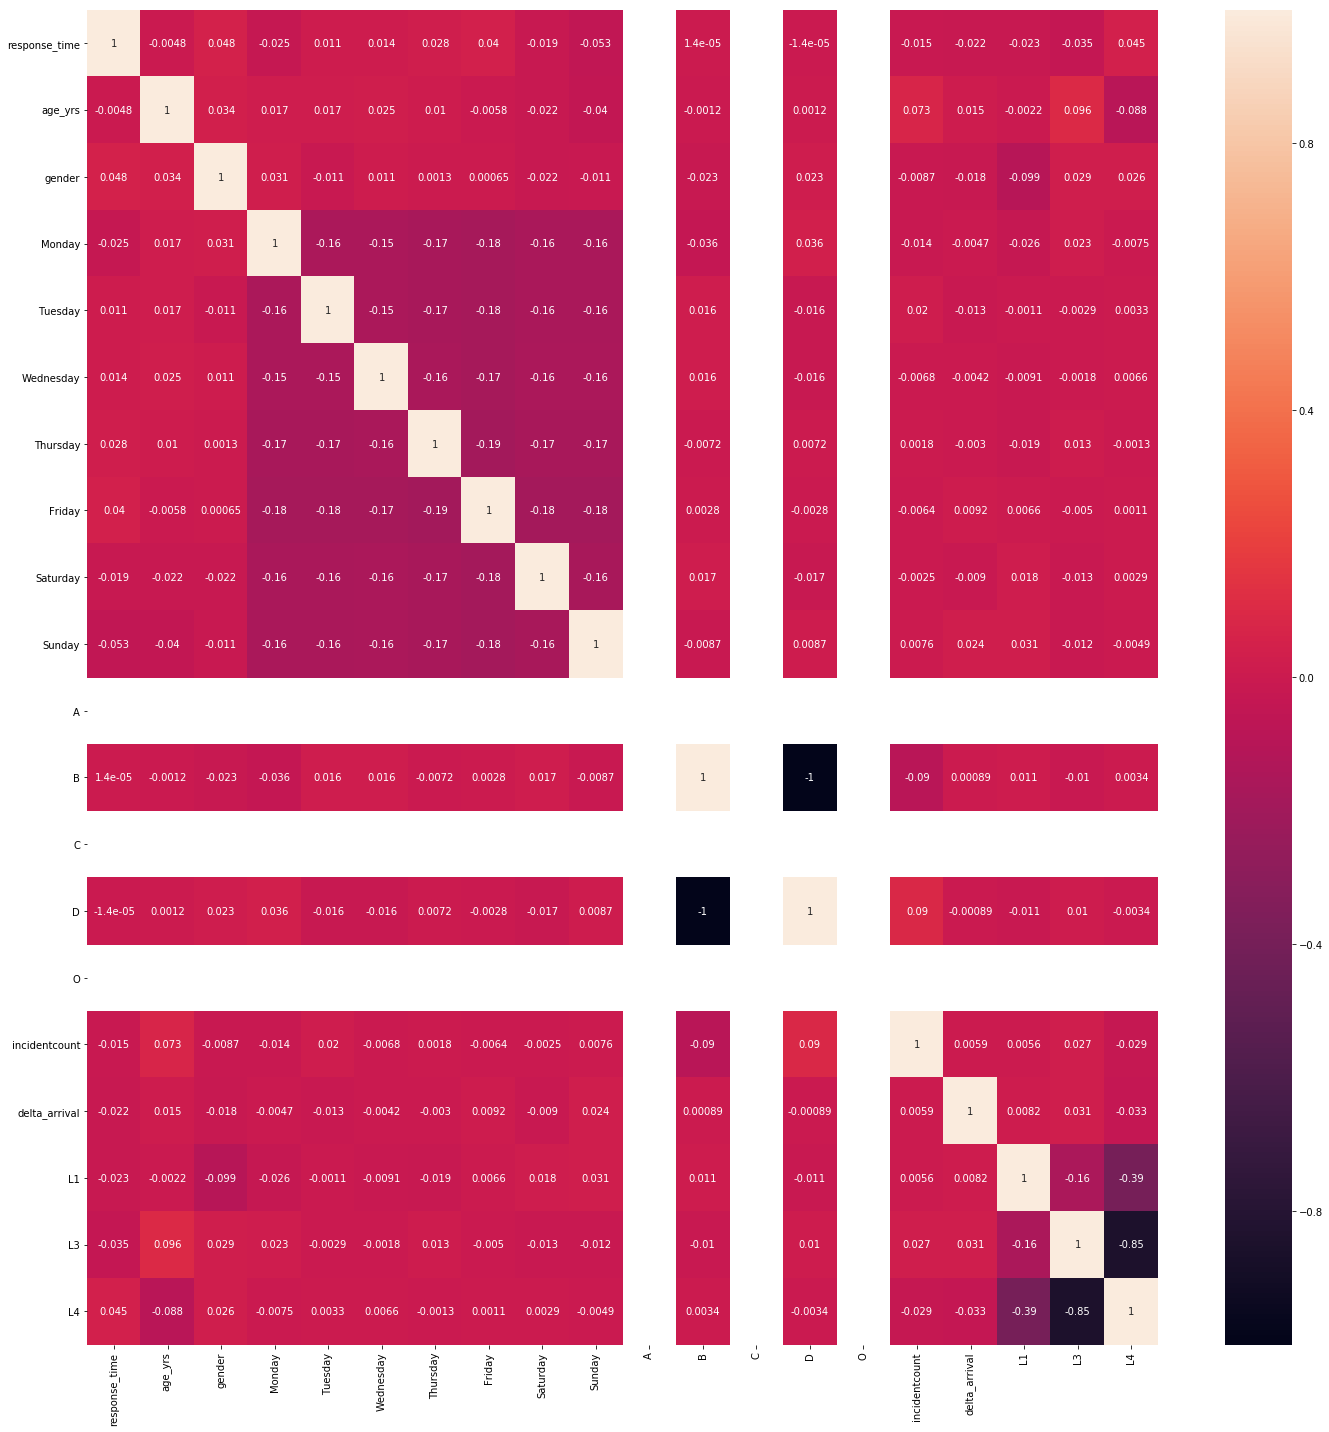

In [32]:
print(train_2904[temp].groupby('class').mean())
# print(train_2904[temp].groupby('class').std())
plt.hist(train_2904['class'],bins=3)
plt.show()
plt.hist(train_2904['disp_problem_lvl'],bins=3)
plt.show()

plt.figure(figsize=[20,20])
corr = train_2904[temp].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

       response_time    age_yrs    gender    Monday   Tuesday  Wednesday  \
class                                                                      
L1         13.749353  63.693367  0.419274  0.131414  0.166458   0.123905   
L3         13.602835  59.568655  0.519683  0.141892  0.148355   0.127497   
L4         13.646641  45.956634  0.536532  0.141585  0.127953   0.142675   

       Thursday    Friday  Saturday    Sunday         A    B         C  \
class                                                                    
L1     0.147685  0.147685  0.145181  0.137672  0.008761  0.0  0.000000   
L3     0.138073  0.153055  0.145417  0.145711  0.044947  0.0  0.021739   
L4     0.147219  0.150127  0.144856  0.145583  0.090149  0.0  0.029444   

              D    O  incidentcount  delta_arrival   L1   L3   L4  
class                                                              
L1     0.991239  0.0       4.002503       0.170288  1.0  0.0  0.0  
L3     0.933314  0.0       3.999119       0.

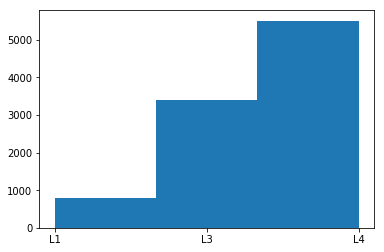

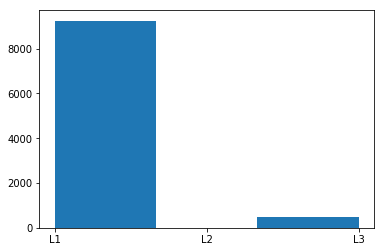

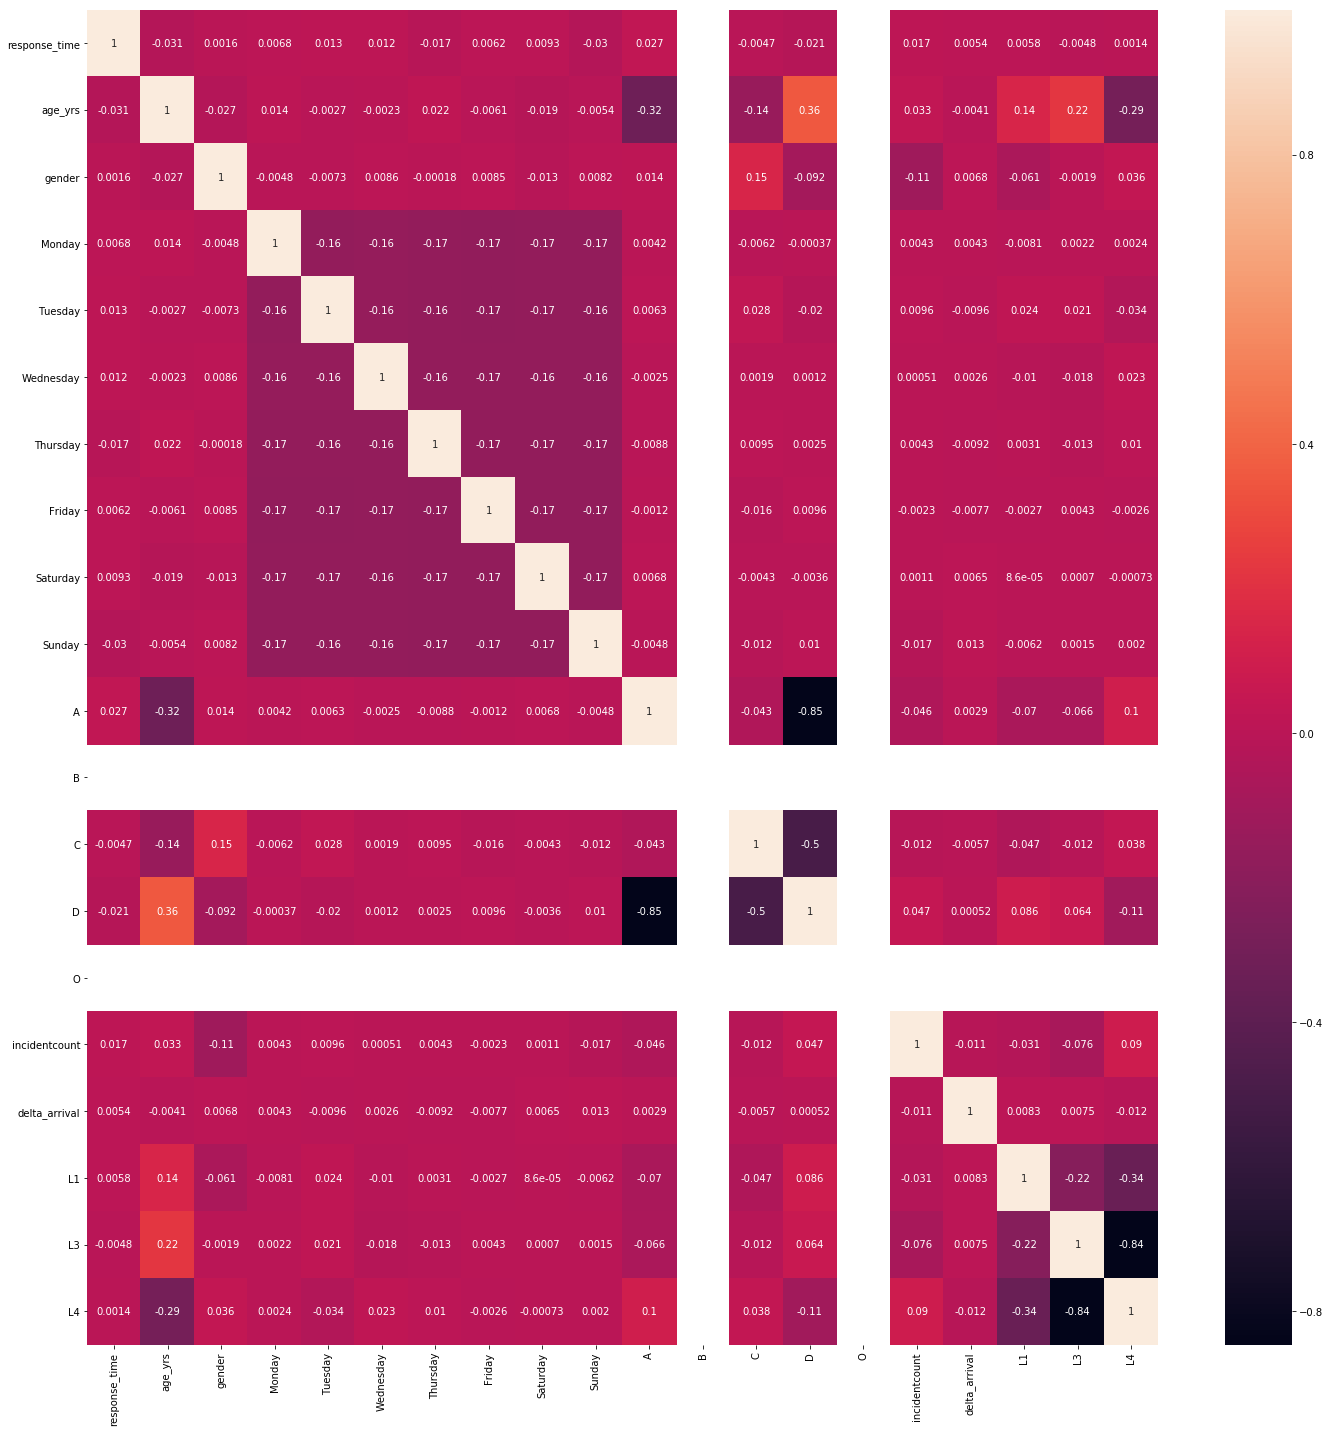

In [33]:
print(train_3103[temp].groupby('class').mean())
# print(train_3103[temp].groupby('class').std())
plt.hist(train_3103['class'],bins=3)
plt.show()
plt.hist(train_3103['disp_problem_lvl'],bins=3)
plt.show()

plt.figure(figsize=[20,20])
corr = train_3103[temp].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2601 model training

In [ ]:
import nltk as nk

In [250]:
features = ['response_time', 'age_yrs', 'gender','A','B','C','D','O','incidentcount', 'delta_arrival',
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# features = ['response_time', 'age_yrs','incidentcount','delta_arrival','gender',
#            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [251]:
model = GNB()
GNB_2601_model = model.fit(train_2601[features], train_2601['class'])
GNB_2601_prob  = model.predict_proba(test_2601[features])

In [276]:
model = LRE(class_weight='balanced', multi_class='multinomial', solver='saga')
LRE_2601_model = model.fit(train_2601[features], train_2601['class'])
LRE_2601_prob  = model.predict_proba(test_2601[features])
LRE_2601_pred  = model.predict(test_2601[features])

In [253]:
model = RFC()
RFC_2601_model = model.fit(train_2601[features], train_2601['class'])
RFC_2601_prob  = model.predict_proba(test_2601[features])

In [254]:
model = GBC()
GBC_2601_model = model.fit(train_2601[features], train_2601['class'])
GBC_2601_prob  = model.predict_proba(test_2601[features])

In [255]:
model = MNB()
MNB_2601_model = model.fit(train_2601[features], train_2601['class'])
MNB_2601_prob  = model.predict_proba(test_2601[features])

In [256]:
model = LRC()
LRC_2601_model = model.fit(train_2601[features], train_2601['class'])
LRC_2601_prob  = model.predict_proba(test_2601[features])

# 2601 testing models

Number of over responses predicted: 5006
Number of over responses assigned:  5057
L1 responses correctly predicted:   92.86%
L1 responses correctly assigned:    94.16%


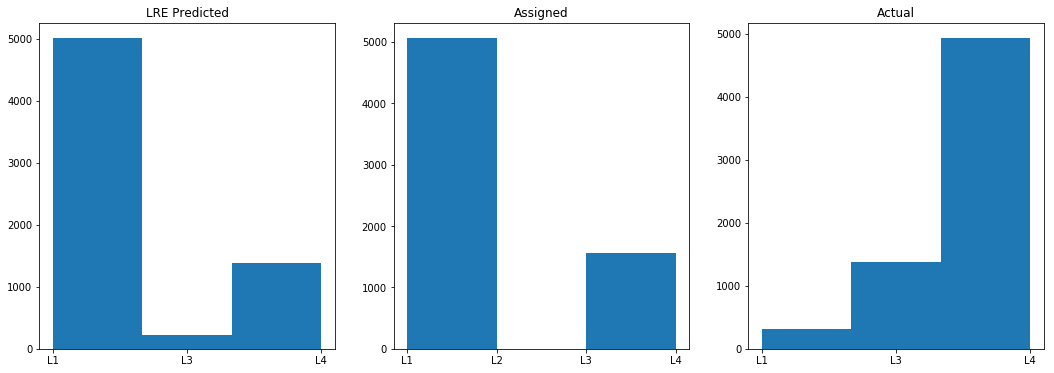

In [280]:
test_2601['LRE_pred'] = 0
test_2601['LRE_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in LRE_2601_prob]
cm1 = cm(test_2601['class'],test_2601['LRE_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['LRE_pred'],bins=3)
plt.title('LRE Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(test_2601[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)

Number of over responses predicted: 2271
Number of over responses assigned:  5057
L1 responses correctly predicted:   49.03%
L1 responses correctly assigned:    94.16%


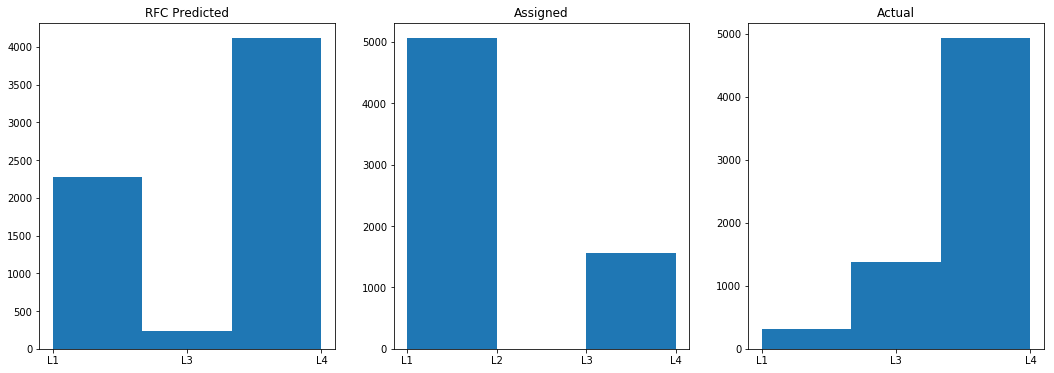

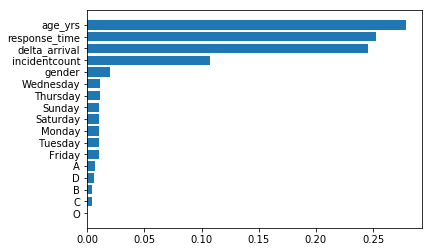

In [258]:
test_2601['RFC_pred'] = 0
test_2601['RFC_pred'] = ['L1' if x[0] > 0.00001 else 'L3' if x[1] > x[2] else 'L4' for x in RFC_2601_prob]
cm1 = cm(test_2601['class'],test_2601['RFC_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['RFC_pred'],bins=3)
plt.title('RFC Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

feature_importance = RFC_2601_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_2601[features].columns[sorted_idx])
plt.show()

Number of actual high lvl response: 308
Number of over responses predicted: 5075
Number of over responses assigned:  5057
L1 responses correctly predicted:   92.53%
L1 responses correctly assigned:    94.16%


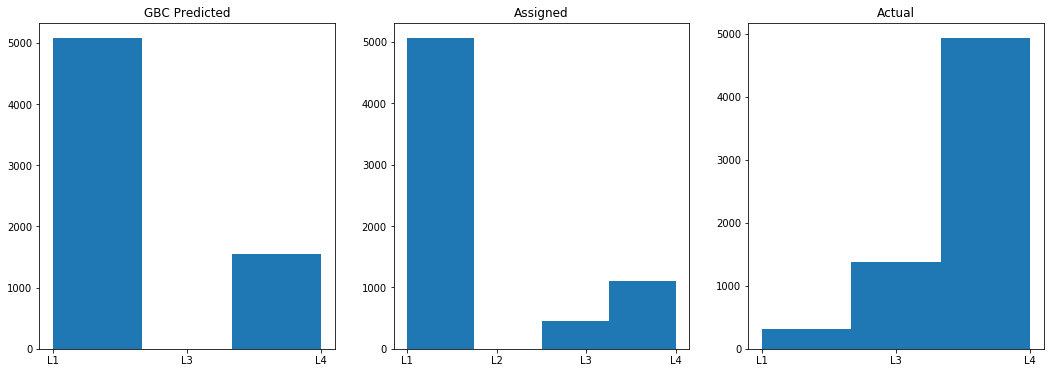

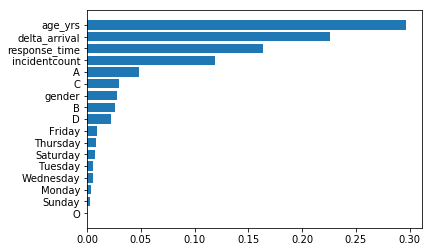

In [259]:
test_2601['GBC_pred'] = 0
test_2601['GBC_pred'] = ['L1' if x[0] > 0.020 else 'L3' if x[1] > x[2] else 'L4' for x in GBC_2601_prob]
cm1 = cm(test_2601['class'],test_2601['GBC_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of actual high lvl response: {}'.format(test_2601['class'][test_2601['class']=='L1'].count()))
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['GBC_pred'],bins=3)
plt.title('GBC Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=4)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

feature_importance = GBC_2601_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_2601[features].columns[sorted_idx])
plt.show()

Number of over responses predicted: 5390
Number of over responses assigned:  5057
L1 responses correctly predicted:   94.81%
L1 responses correctly assigned:    94.16%


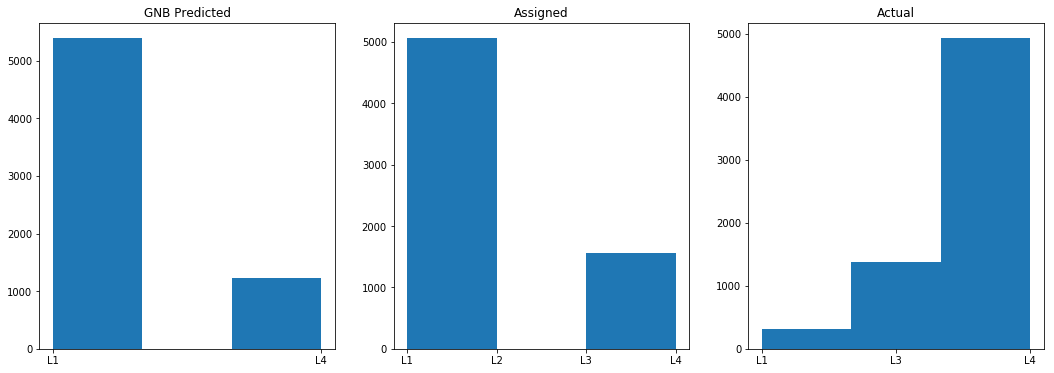

In [260]:
test_2601['GNB_pred'] = 0
test_2601['GNB_pred'] = ['L1' if x[0] > 0.0012 else 'L3' if x[1] > x[2] else 'L4' for x in GNB_2601_prob]
cm1 = cm(test_2601['class'],test_2601['GNB_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['GNB_pred'],bins=3)
plt.title('GNB Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

Number of over responses predicted: 5449
Number of over responses assigned:  5057
L1 responses correctly predicted:   91.23%
L1 responses correctly assigned:    94.16%


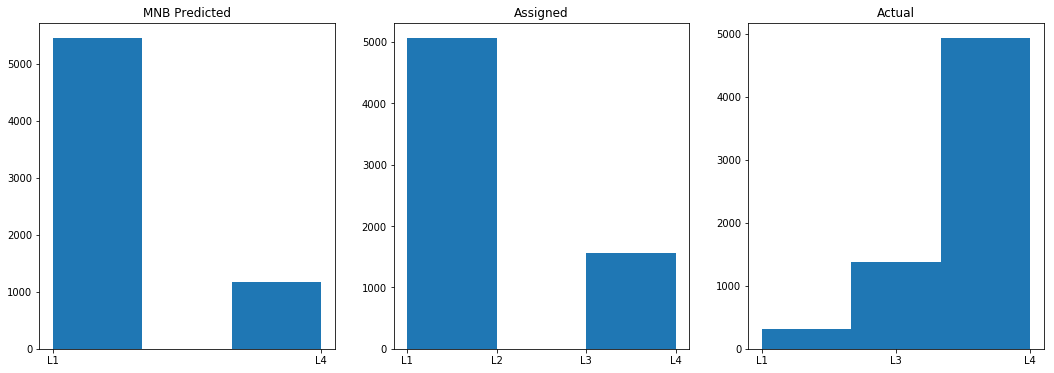

In [261]:
test_2601['MNB_pred'] = 0
test_2601['MNB_pred'] = ['L1' if x[0] > 0.001 else 'L3' if x[1] > x[2] else 'L4' for x in MNB_2601_prob]
cm1 = cm(test_2601['class'],test_2601['MNB_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['MNB_pred'],bins=3)
plt.title('MNB Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

Number of over responses predicted: 4583
Number of over responses assigned:  5057
L1 responses correctly predicted:   82.47%
L1 responses correctly assigned:    94.16%


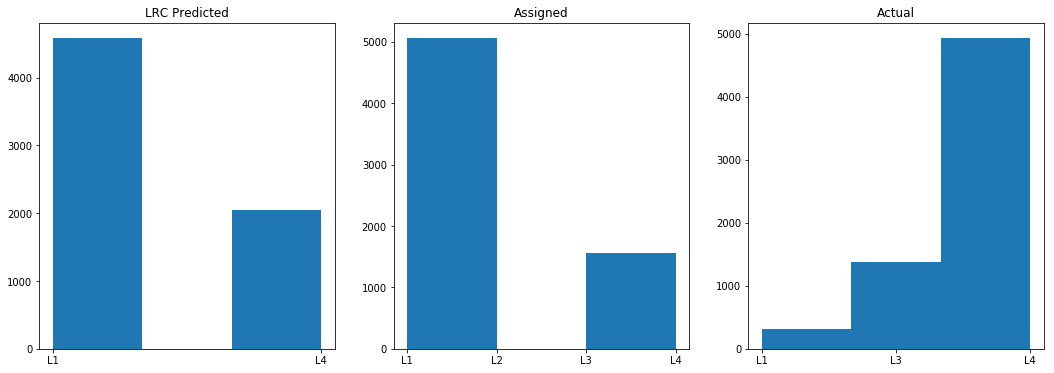

In [262]:
test_2601['LRC_pred'] = 0
test_2601['LRC_pred'] = ['L1' if x[0] > 0.04 else 'L3' if x[1] > x[2] else 'L4' for x in LRC_2601_prob]
cm1 = cm(test_2601['class'],test_2601['LRC_pred'])
cm2 = cm(test_2601['class'],test_2601['disp_problem_lvl'])
# print(cm1,'\n')
# print(cm2,'\n')
temp0 = np.sum(cm1[:,0])
temp1 = np.sum(cm2[:,0])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[0,0]/np.sum(cm1[0])
temp1 = cm2[0,0]/np.sum(cm2[0])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(test_2601['LRC_pred'],bins=3)
plt.title('LRC Predicted')
plt.subplot(1,3,2)
plt.hist(test_2601['disp_problem_lvl'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(test_2601['class'],bins=3)
plt.title('Actual')
plt.show()

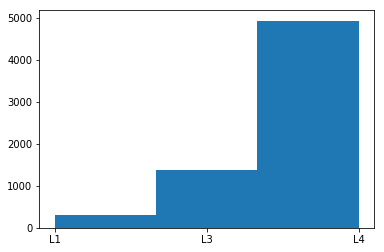

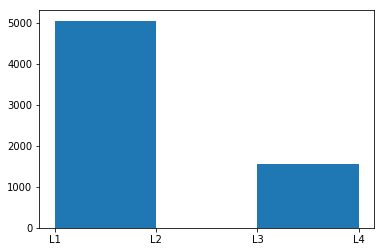

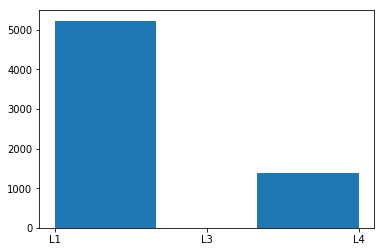

In [46]:
plt.hist(test_2601['class'], bins=3)
plt.show()
plt.hist(test_2601['disp_problem_lvl'], bins=3)
plt.show()
plt.hist(test_2601['GBC_pred'], bins=3)
plt.show()

In [47]:
print(cm(test_2601['class'],test_2601['GBC_pred']))

[[ 288    0   20]
 [1203    1  180]
 [3739    0 1193]]


In [48]:
print(cm(test_2601['class'],test_2601['disp_problem_lvl']))

[[ 290    0   10    8]
 [   0    0    0    0]
 [1122    2  124  136]
 [3645    2  323  962]]


In [49]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(df_06D02['class'].unique),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=(df_06D02['class'].unique), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')